### Importing the required Libraries


In [136]:
# Data Wrangling
import pandas as pd

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

# Data Visualization
import seaborn as sb
import matplotlib.pyplot as mplt

### Importing Dataset


Importing the dataset that has all features (NLP + Similarity)


In [137]:
phishing_dt = pd.read_csv("./Phishing_Email_Rich_Sim.csv")
phishing_dt.head()

,Index,Email Text,Email Type,Lexical Errors,URL Verification,scores,compound,Sentiment,TB_score,TB_sentiment,Emotion,Email Text New,Phishing Similarity
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,25.652174,NaN,"{'neg': 0.031, 'neu': 0.812, 'pos': 0.157, 'co...",0.9795,Positive,"Sentiment(polarity=0.17013888888888887, subjec...",0.170139,positive,disc uniformitarianism sex lang dick hud...,0.011487
1,1,the other side of * galicismos * * galicismo *...,Safe Email,28.571429,NaN,"{'neg': 0.0, 'neu': 0.966, 'pos': 0.034, 'comp...",0.3612,Positive,"Sentiment(polarity=0.009375000000000001, subje...",0.009375,negative,the other side of galicismos galicismo is ...,0.019268
2,2,re : equistar deal tickets are you still avail...,Safe Email,20.000000,NaN,"{'neg': 0.0, 'neu': 0.939, 'pos': 0.061, 'comp...",0.8591,Positive,"Sentiment(polarity=0.09154040404040405, subjec...",0.091540,positive,equistar deal tickets are you still available ...,0.005855
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,15.625000,Safe,"{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...",0.9696,Positive,"Sentiment(polarity=0.23333333333333334, subjec...",0.233333,positive,hello i am your hot lil horny toy i am the...,0.020337
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,42.857143,NaN,"{'neg': 0.106, 'neu': 0.72, 'pos': 0.174, 'com...",0.4767,Positive,"Sentiment(polarity=0.15257936507936506, subjec...",0.152579,positive,software at incredibly low prices lower d...,1.000000


### Processing the data for Model


Labelling the text values


In [138]:
target_column = phishing_dt.pop(phishing_dt.columns[2])
phishing_dt["Email Type"] = target_column
phishing_dt["URL Verification"] = phishing_dt["URL Verification"].fillna("No URL")
phishing_dt = phishing_dt.drop("Index", axis=1)
phishing_dt = phishing_dt.drop("scores", axis=1)
phishing_dt = phishing_dt.drop("TB_score", axis=1)

label_encoder = LabelEncoder()
phishing_dt["URL Verification"] = label_encoder.fit_transform(
    phishing_dt["URL Verification"]
)
phishing_dt["Emotion"] = label_encoder.fit_transform(phishing_dt["Emotion"])
phishing_dt["Sentiment"] = label_encoder.fit_transform(phishing_dt["Sentiment"])

Performing vectorization creating features using Email Text


In [139]:
vectorizer = TfidfVectorizer(max_features=200)

tfidf_matrix_email_text = vectorizer.fit_transform(phishing_dt["Email Text"])
tfidf_df_email_text = pd.DataFrame(
    tfidf_matrix_email_text.toarray(), columns=vectorizer.get_feature_names_out()
)

Creating final dataframe


In [140]:
phishing_dt_no_email = phishing_dt.drop(columns=["Email Text", "Email Text New"])

phishing_dt_final = pd.concat(
    [phishing_dt_no_email, tfidf_df_email_text], axis=1, ignore_index=False
)

phishing_dt_final.head()

,Lexical Errors,URL Verification,compound,Sentiment,TB_sentiment,Emotion,Phishing Similarity,Email Type,00,000,...,with,within,work,world,would,www,year,you,your,½ï
0,25.652174,0,0.9795,2,0.170139,7,0.011487,Safe Email,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0
1,28.571429,0,0.3612,2,0.009375,6,0.019268,Safe Email,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.15423,0.000000,0.0,0.094384,0.000000,0.0
2,20.000000,0,0.8591,2,0.091540,7,0.005855,Safe Email,0.0,0.0,...,0.112428,0.0,0.0,0.0,0.00000,0.000000,0.0,0.099227,0.000000,0.0
3,15.625000,1,0.9696,2,0.233333,7,0.020337,Phishing Email,0.0,0.0,...,0.069417,0.0,0.0,0.0,0.00000,0.097343,0.0,0.183800,0.375534,0.0
4,42.857143,0,0.4767,2,0.152579,7,1.000000,Phishing Email,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0


### Data Splitting


Splitting data into X and y


In [141]:
X = phishing_dt_final.drop(columns=["Email Type"])
y = phishing_dt_final["Email Type"]

In [142]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

### Random Forest Classifier


Training the Classifier Model


In [143]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Testing the Classifier Model


In [144]:
rf_y_pred = classifier.predict(X_test)

Model Accuracy


In [145]:
rf_accuracy = accuracy_score(y_test, rf_y_pred)
phishing_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

print(f"The Random Forest Classifier Model has an accuracy of {rf_accuracy}")

The Random Forest Classifier Model has an accuracy of 0.954629164573916


Heatmap visualization of the Confusion Matrix

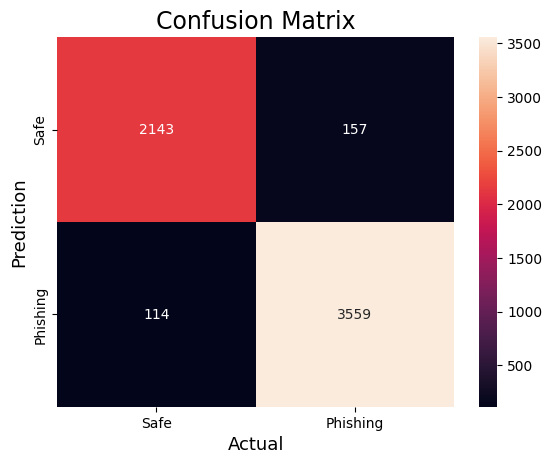

In [146]:
sb.heatmap(
    phishing_confusion_matrix,
    annot=True,
    fmt="g",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
mplt.ylabel("Prediction", fontsize=13)
mplt.xlabel("Actual", fontsize=13)
mplt.title("Confusion Matrix", fontsize=17)
mplt.show()

### SVM Model


Creating a SVM Model

In [147]:
model_svm = SVC(C=100, gamma="auto")

Training the SVM Model

In [148]:
model_svm.fit(X_train, y_train)

SVC(C=100, gamma='auto')

Testing the SVM Model

In [149]:
svm_y_pred = model_svm.predict(X_test)

Accuracy and Confusion Matrix

In [150]:
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_confusion_matrix = confusion_matrix(y_test, svm_y_pred)

print(f'The SVM Model has an accuracy of {svm_accuracy}')

The SVM Model has an accuracy of 0.9382219989954796


Heatmap visualization of the Confusion Matrix

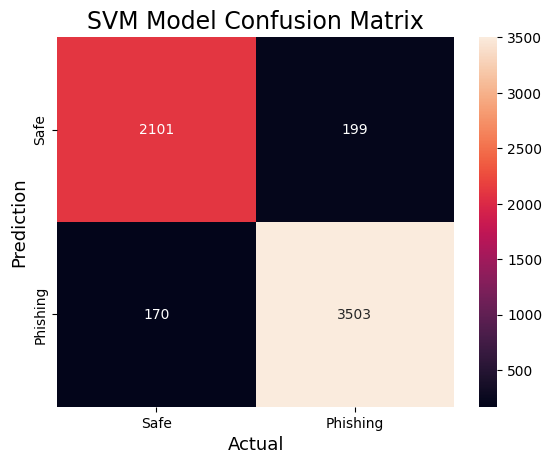

In [151]:
sb.heatmap(
    svm_confusion_matrix,
    annot=True,
    fmt="g",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
mplt.ylabel("Prediction", fontsize=13)
mplt.xlabel("Actual", fontsize=13)
mplt.title("SVM Model Confusion Matrix", fontsize=17)
mplt.show()

### XGB Classifier

Defining KFold for the XGB Classifier

In [152]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

Creating a helper function

In [153]:
def print_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val, y_pred)}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')

Creating X and y for the XGB Classifier

In [154]:
x_full_reset = phishing_dt_final.drop(columns=['Email Type']).reset_index(drop=True)
y_reset = y.reset_index(drop=True)

In [155]:
y_encoded = label_encoder.fit_transform(y)

Training and Testing the XGB Classifier

In [156]:
fold = 1
n_estim = 100
for train_index, val_index in kfold.split(x_full_reset):
  X_train, X_val = x_full_reset.iloc[train_index], x_full_reset.iloc[val_index]
  y_train, y_val = y_encoded[train_index], y_encoded[val_index]
  model = XGBClassifier(n_estimators=n_estim, learning_rate=0.1, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=42,enable_categorical=True)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  print_report(y_val, y_pred, fold)
  xgb_confusion_matrix = confusion_matrix(y_val, y_pred)
  fold += 1

Fold: 1
Accuracy Score: 0.9348066298342541
Confusion Matrix: 
 [[1250  110]
 [ 126 2134]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      1360
           1       0.95      0.94      0.95      2260

    accuracy                           0.93      3620
   macro avg       0.93      0.93      0.93      3620
weighted avg       0.93      0.93      0.93      3620

Fold: 2
Accuracy Score: 0.9477900552486188
Confusion Matrix: 
 [[1332   99]
 [  90 2099]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      1431
           1       0.95      0.96      0.96      2189

    accuracy                           0.95      3620
   macro avg       0.95      0.94      0.95      3620
weighted avg       0.95      0.95      0.95      3620

Fold: 3
Accuracy Score: 0.9466850828729282
Confusion Matrix: 
 [[1319   80]
 [ 113 2108]]
Classification Report: 
  

Heatmap visualization of the Confusion Matrix

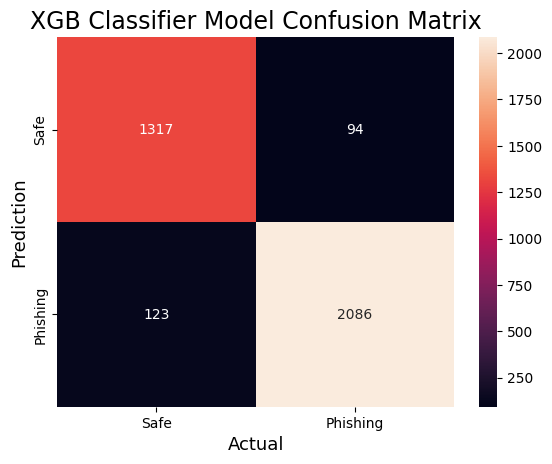

In [157]:
sb.heatmap(
    xgb_confusion_matrix,
    annot=True,
    fmt="g",
    xticklabels=["Safe", "Phishing"],
    yticklabels=["Safe", "Phishing"],
)
mplt.ylabel("Prediction", fontsize=13)
mplt.xlabel("Actual", fontsize=13)
mplt.title("XGB Classifier Model Confusion Matrix", fontsize=17)
mplt.show()